In [2]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import sklearn
import re


from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
# Reset display settings 

pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.max_colwidth = 70

#pd.get_option("display.max_rows", None)
#pd.get_option("display.max_columns", None)
#pd.set_option("expand_frame_repr", False)
#pd.set_option("display.max_colwidth", 80)

In [4]:
%matplotlib inline
# importing every dataset and change your paths
train=pd.read_csv("/Users/zhiliwang/Documents/nlp/kaggle/data/train.csv")
test=pd.read_csv("/Users/zhiliwang/Documents/nlp/kaggle/data/test.csv")
ss=pd.read_csv("/Users/zhiliwang/Documents/nlp/kaggle/data/sample_submission.csv")
ds = ['train', 'test', 'sample submission']
print("Training set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("Test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))
# columns/features:
print(train.columns)
print(test.columns)

Training set has 7613 rows and 5 columns.
Test set has 3263 rows and 4 columns.
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [5]:
# execute these in all 3 datasets to check them out
print("-" * 45, ds[0], "-" * 45)
print(train.head(), '\n')
print("-" * 45, ds[1], "-" * 45)
print(test.head(), '\n')
print("-" * 40, ds[2], "-" * 40)
print(ss.head())

--------------------------------------------- train ---------------------------------------------
   id keyword location                                                                   text  target
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1   4     NaN      NaN                                 Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are being notified by of...       1
3   6     NaN      NaN      13,000 people receive #wildfires evacuation orders in California        1
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as smoke from #wildfire...       1 

--------------------------------------------- test ---------------------------------------------
   id keyword location                                                                   text
0   0     NaN      NaN                                     Just happened a terrible car crash
1  

In [6]:
print("-" * 45, ds[0], "-" * 45)

print('\nData type of each column of %s dataset:' %(ds[0]))
print(train.dtypes)
print('\nkeyword:', type(test['keyword'][0]))
print('location:', type(test['location'][0]))
print('text:', type(test['text'][0]))

print("-" * 45, ds[1], "-" * 45)
print('\nData type of each column of %s dataset:' %(ds[1]))
print(test.dtypes)
print('\nkeyword:', type(test['keyword'][0]))
print('location:', type(test['location'][0]))
print('text:', type(test['text'][0]))

# conclusion: need to be cautious that keyword and location elements are floats, not strings

--------------------------------------------- train ---------------------------------------------

Data type of each column of train dataset:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

keyword: <class 'float'>
location: <class 'float'>
text: <class 'str'>
--------------------------------------------- test ---------------------------------------------

Data type of each column of test dataset:
id           int64
keyword     object
location    object
text        object
dtype: object

keyword: <class 'float'>
location: <class 'float'>
text: <class 'str'>


In [7]:
print("-" * 45, ds[0], "-" * 45)
for i in train.columns: 
    if len(set(train[i])) == len(train[i]):
        print('All elements in %s column of %s dataset are unique.' % (i, ds[0]))
    else:
        print('Not all the elements in %s column of %s dataset are unique.' % (i, ds[0]))

print("-" * 45, ds[1], "-" * 45)
for j in test.columns: 
    if len(set(test[j])) == len(test[j]):
        print('All elements in %s column of %s dataset are unique.' % (j, ds[1]))
    else:
        print('Not all the elements in %s column of %s dataset are unique.' % (j, ds[1]))

--------------------------------------------- train ---------------------------------------------
All elements in id column of train dataset are unique.
Not all the elements in keyword column of train dataset are unique.
Not all the elements in location column of train dataset are unique.
Not all the elements in text column of train dataset are unique.
Not all the elements in target column of train dataset are unique.
--------------------------------------------- test ---------------------------------------------
All elements in id column of test dataset are unique.
Not all the elements in keyword column of test dataset are unique.
Not all the elements in location column of test dataset are unique.
Not all the elements in text column of test dataset are unique.


--------------------------------------------- train ---------------------------------------------
   target  counts
0       0    4342
1       1    3271


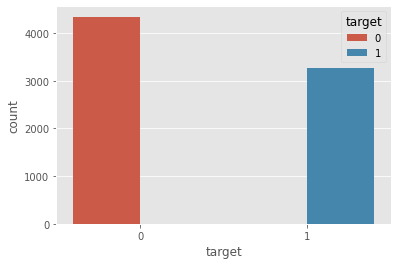

In [13]:
# train's target
print("-" * 45, ds[0], "-" * 45)
temp = train['target'].value_counts(dropna = False).reset_index()
temp.columns = ['target', 'counts']
print(temp)

sns.countplot(x = 'target', data = train, hue = train['target'])

In [9]:
# don't need to do anything with sample submission, checking just in case:
print("-" * 45, ds[2], "-" * 45)
print(ss['target'].value_counts(dropna = False))
# All 0's

--------------------------------------------- sample submission ---------------------------------------------
0    3263
Name: target, dtype: int64


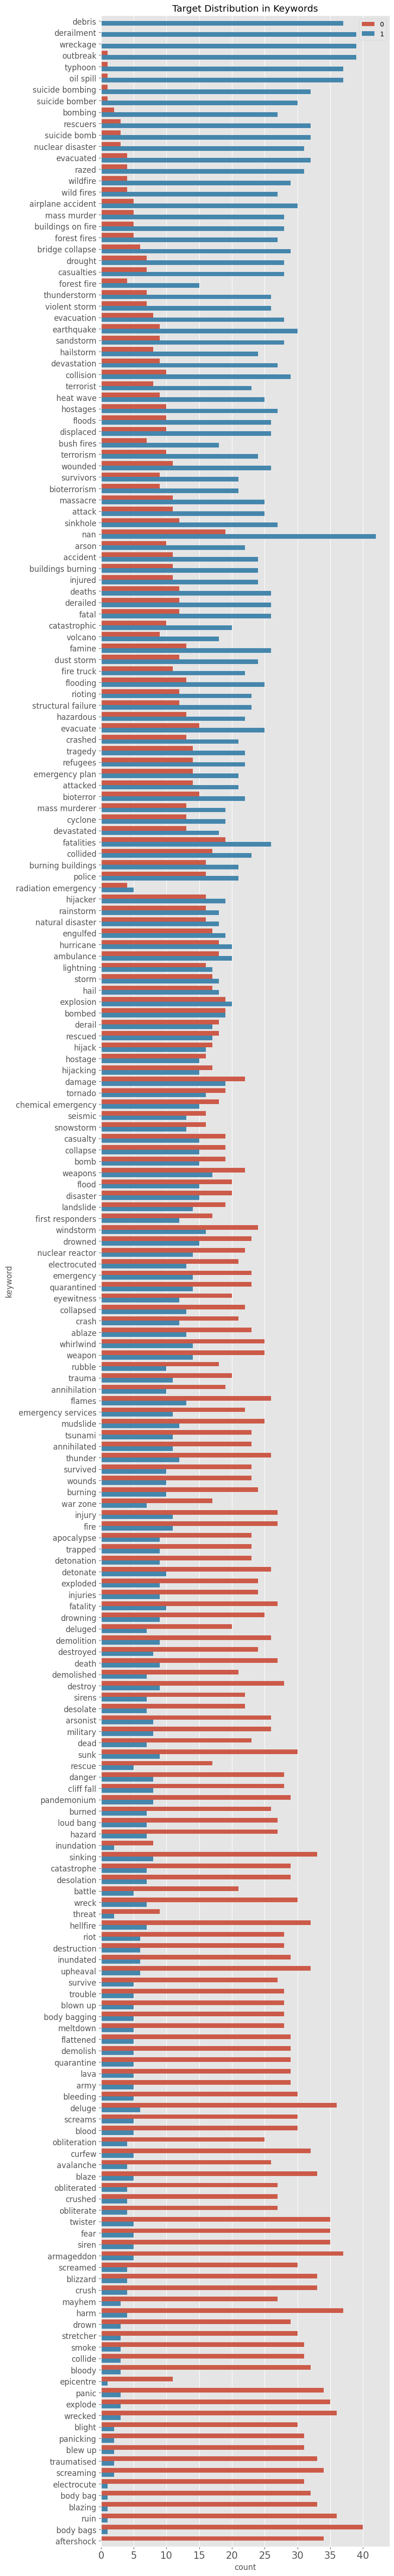

In [15]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

In [16]:
# not checking 'id' since all unique
# not checking 'text' for now, need major work on it later

# unique values of "keyword" column and their occurences 
train_key_un = train['keyword'].value_counts(dropna = False)
print('-'*40, "train set's keyword column (raw)", '-'*40, '\n')
### check data before cleaning:
### print(train_key_un)
### if you prefer to read it as a dictionary:
print(train_key_un.to_dict())

# keywords are suprisingly good, easy to clean and very few unknowns/NaN


---------------------------------------- train set's keyword column (raw) ---------------------------------------- 

{'nan': 61, 'fatalities': 45, 'armageddon': 42, 'deluge': 42, 'sinking': 41, 'damage': 41, 'body bags': 41, 'harm': 41, 'collided': 40, 'outbreak': 40, 'siren': 40, 'windstorm': 40, 'twister': 40, 'fear': 40, 'evacuate': 40, 'sunk': 39, 'derailment': 39, 'wrecked': 39, 'earthquake': 39, 'weapons': 39, 'whirlwind': 39, 'weapon': 39, 'hellfire': 39, 'explosion': 39, 'flames': 39, 'wreckage': 39, 'famine': 39, 'sinkhole': 39, 'collision': 39, 'hurricane': 38, 'bombed': 38, 'injury': 38, 'typhoon': 38, 'oil spill': 38, 'fatal': 38, 'thunder': 38, 'derailed': 38, 'explode': 38, 'deaths': 38, 'flooding': 38, 'ambulance': 38, 'upheaval': 38, 'drowned': 38, 'blaze': 38, 'fire': 38, 'destroy': 37, 'blizzard': 37, 'emergency': 37, 'pandemonium': 37, 'hostages': 37, 'fatality': 37, 'burning buildings': 37, 'police': 37, 'crush': 37, 'quarantined': 37, 'bioterror': 37, 'panic': 37, 

In [20]:
print('-'*40, "test set's keyword column (raw)", '-'*40, '\n')
# unique values of test set's keyword" column and their occurences 
test_key_un = test['keyword'].value_counts(dropna = False)

### check data before cleaning:
### print(test_key_un)
print(test_key_un.to_dict())

---------------------------------------- test set's keyword column (raw) ---------------------------------------- 

{nan: 26, 'deluged': 23, 'rubble': 22, 'demolished': 22, 'first%20responders': 21, 'sirens': 21, 'obliteration': 21, 'snowstorm': 21, 'annihilation': 21, 'seismic': 21, 'dead': 20, 'bioterrorism': 20, 'survivors': 20, 'mayhem': 20, 'catastrophic': 20, 'avalanche': 20, 'crushed': 19, 'trauma': 19, 'obliterated': 19, 'devastated': 19, 'wild%20fires': 19, 'obliterate': 19, 'hostage': 19, 'suicide%20bomber': 19, 'terrorist': 19, 'electrocute': 18, 'apocalypse': 18, 'forest%20fires': 18, 'blight': 18, 'survive': 18, 'cyclone': 18, 'trapped': 18, 'arson': 18, 'destroyed': 18, 'hijacking': 18, 'hailstorm': 18, 'eyewitness': 18, 'detonation': 18, 'drown': 18, 'exploded': 17, 'blown%20up': 17, 'survived': 17, 'mass%20murder': 17, 'injuries': 17, 'stretcher': 17, 'blew%20up': 17, 'burned': 17, 'body%20bag': 17, 'panicking': 17, 'trouble': 17, 'landslide': 17, 'fire%20truck': 17, 'b

In [21]:
print('-'*40, "train set's location column (raw)", '-'*40, '\n')
# unique values of "keyword" column and their occurences 
# unique values of train set's "location" column and their occurences 
train_loc_un = train['location'].value_counts(dropna = False)

### check data before cleaning:
### print(train_location_un)
### if you prefer to read it as a dictionary:
print(train_location_un.to_dict())

# keywords are suprisingly good, easy to clean and very few unknowns/NaN


---------------------------------------- train set's location column (raw) ---------------------------------------- 



In [22]:
# test's location
# unique values of "location" column and their occurences 
print('-'*40, "test set's location column (raw)", '-'*40, '\n')
test_loc_un = test['location'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(test_loc_un))
test_loc_un = test_loc_un.reset_index()
test_loc_un.columns = ['locations', 'count']
# check data before cleaning:
# print(test_loc_un)


### 'text' column
print('-'*40, "test set's text column (raw)", '-'*40, '\n')
# unique values of "text" column and their occurences 
test_text_un = test['text'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(test_text_un))
test_text_un = test_text_un.reset_index()
test_text_un.columns = ['text', 'count']
# check data before cleaning:
# print(text_text_un)
### if you want to see text's unique values:
# only in this cell:
# print(test_text_un)

# super dirty, will work on it Tuesday night

# cleaning:
# open to suggestion


# check raw data after cleaning: 
# print(test['text']
# check unique values and their frequencies again, after cleaning:
print(test['text'])


### i got diagrams coming up too

---------------------------------------- test set's location column (raw) ---------------------------------------- 

There are 1603 unique elements, including "NaN".
---------------------------------------- test set's text column (raw) ---------------------------------------- 

There are 3243 unique elements, including "NaN".
0                                          Just happened a terrible car crash
1            Heard about #earthquake is different cities, stay safe everyone.
2       there is a forest fire at spot pond, geese are fleeing across the ...
3                                    Apocalypse lighting. #Spokane #wildfires
4                               Typhoon Soudelor kills 28 in China and Taiwan
5                                          We're shaking...It's an earthquake
6       They'd probably still show more life than Arsenal did yesterday, e...
7                                                           Hey! How are you?
8                                               

In [23]:

'''
# unique values of "location" column and their occurences 

test_loc_un = test['location'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(test_loc_un))
test_loc_un = test_loc_un.reset_index()
test_loc_un.columns = ['locations', 'count']
# check data before cleaning:
# print(test_loc_un)


### 'text' column

# unique values of "text" column and their occurences 
test_text_un = test['text'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(test_text_un))
test_text_un = test_text_un.reset_index()
test_text_un.columns = ['text', 'count']
# check data before cleaning:
# print(text_text_un)
### if you want to see text's unique values:
# only in this cell:
# print(test_text_un)

# super dirty, will work on it Tuesday night

# cleaning:
# open to suggestion


# check raw data after cleaning: 
# print(test['text']
# check unique values and their frequencies again, after cleaning:
print(test['text'])


### i got diagrams coming up too

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-23-c3ac5d1a8ca2>, line 37)

<Blank>

<Blank>

Cleaning:

In [ ]:
# clean keyword:
# Un-URLification: changing '%20' back to spaces
# must cast, modify, and replace every individual element within each column to work:
for i in range(len(train['keyword'])):
    train['keyword'][i] = str(train['keyword'][i]).replace('%20', ' ')

train_key_un = train['keyword'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(train_key_un))
train_key_un = train_key_un.reset_index()
train_key_un.columns = ['keyword', 'count']

# check raw data after cleaning: 
# print(train['keyword']
# check unique values and their frequencies again, after cleaning:
print(train_key_un)

In [ ]:
# clean keyword:
# Un-URLification: changing '%20' back to spaces
# must cast, modify, and replace every individual element within each column to work:
for i in range(len(train['keyword'])):
    train['keyword'][i] = str(train['keyword'][i]).replace('%20', ' ')

train_key_un = train['keyword'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(train_key_un))
train_key_un = train_key_un.reset_index()
train_key_un.columns = ['keyword', 'count']

# check raw data after cleaning: 
# print(train['keyword']
# check unique values and their frequencies again, after cleaning:
print(train_key_un)

In [25]:
# cleaning:
# in order to clean location, we must standardize a location format (e.g. "city, state, nation")
# change all meaningless terms to "nan"
# if centain terms are specific enough then worth to investigate individually



# check raw data after cleaning: 
# print(test['loc']
# check unique values and their frequencies again, after cleaning:
print(test_loc_un)

# clean keyword:
# Un-URLification: changing '%20' back to spaces
# must cast, modify, and replace every individual element within each column to work:
for i in range(len(test['keyword'])):
    test['keyword'][i] = str(test['keyword'][i]).replace('%20', ' ')

test_key_un = test['keyword'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(test_key_un))
test_key_un = test_key_un.reset_index()
test_key_un.columns = ['keyword', 'count']

# check raw data after cleaning: 
# print(test['keyword']
# check unique values and their frequencies again, after cleaning:
print(test_key_un)

NameError: name 'test_loc_un' is not defined

In [21]:
### 'text' column

# unique values of "text" column and their occurences 
test_text_un = test['text'].value_counts(dropna = False)
print('There are %d unique elements, including "NaN".' % len(test_text_un))
test_text_un = test_text_un.reset_index()
test_text_un.columns = ['text', 'count']
# check data before cleaning:
# print(text_text_un)
### if you want to see text's unique values:
# only in this cell:
# print(test_text_un)

# super dirty, will work on it Tuesday night

# cleaning:
# open to suggestion


# check raw data after cleaning: 
# print(test['text']
# check unique values and their frequencies again, after cleaning:
print(test['text'])


### i got diagrams coming up too

There are 3243 unique elements, including "NaN".
0                                          Just happened a terrible car crash
1            Heard about #earthquake is different cities, stay safe everyone.
2       there is a forest fire at spot pond, geese are fleeing across the ...
3                                    Apocalypse lighting. #Spokane #wildfires
4                               Typhoon Soudelor kills 28 in China and Taiwan
5                                          We're shaking...It's an earthquake
6       They'd probably still show more life than Arsenal did yesterday, e...
7                                                           Hey! How are you?
8                                                            What a nice hat?
9                                                                   Fuck off!
10                                                      No I don't like cold!
11                                                 NOOOOOOOOO! Don't do that!
12             